# Piff Tutorial

### Links

Before we get started, here are some potentially useful links.

* [Piff main repo](https://github.com/rmjarvis/Piff)
* [Piff documentation](http://rmjarvis.github.io/Piff/_build/html/index.html)
* [DES Y3 PSF paper](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)
* [ASCL 2102.024](https://ascl.net/2102.024)

### Overview

Piff is primarily designed to be run from the command line using a configuration file.  The (primate) executable is called `piffify`, so the most straightforwared usage would be to run e.g.
```
piffify config.yaml
```

It is also typical to change individual configuration items on the command line that are meant to change for each exposure or each input image.  So perhaps a more typical usage would look something like
```
piffify config.yaml input.image_file_name=D00572501_z_c01_r3624p01_immasked.fits.fz input.cat_file_name=D00572501_z_c01_r5473p01_piff.fits output.file_name=D00572501_z_c01.piff
```
There may be additional items you might want to change besides these, but the names of input and output files are extremely common to set on the command line.

### Config structure

There are usually either 3 or 4 sections of the configuration file:

1. `input` defines all of the input data that Piff will use to constrain the PSF model.  At a minimum, this includes the image file name and the input catalog with positions of the stars.  It also defines what column names in the input catalog correspond to things like x,y or ra,dec, and what columsn are needed for other things like sky subtraction or star selection.

2. `select` defines how to select the candidate stars from the input catalog.  There are several ways to do this, but the easiest is some calculation based on property columns.  There is also a size-magnitude selector which looks for the stellar locus in a size-magnitude diagram.  If this section is omitted, then all input objects that are not flagged are considered to be candidate stars.

3. `psf` defines the PSF model.  This typically involves two parts: the model profile at any given location, and how that profile should be interpolated across the field of view.  This section may also define an outlier rejection scheme to remove bad fits from further consideration.

4. `output` defines what file(s) to write to disk.  This may just be the Piff output file that defines the model (which other codes could then use to render PSF models), but it can also include additional plots and output catalogs in a `stats` field.  (More on that below.)

All fields have a `type` (possibly implicit if there is a useful default), which governs what other parameters are expected/allowed in that field.  This closely match onto Python classes and the other items are like initialization parameters.

For instance models may be any of the following types currently:
* Gaussian
* Moffat
* Kolmogorov
* PixelGrid
* Optical

The currently implemented interpolation schemes are:
* Mean
* Polynomial
* BasisPolynomial
* kNNInterp
* GPInterp

This structure makes all parts of the code very modular.  It is easy to add a new type for some part of the calculation, which a user can then specify in their config file to change the behavior of Piff for their use case.

In [1]:
# Here is a relatively simple configuration for DES Y6 data:

from textwrap import dedent
import yaml


config = dedent("""
    input:
    
        # dir is optional.  If set, it applies to all file names here without an absolute path
        dir: 572501
        
        # Define the input image with the pixel data.
        # These data come with a bad pixel mask and a weight map.
        image_file_name: D00572501_z_c01_r3624p01_immasked.fits.fz
        image_hdu: 1
        badpix_hdu: 2
        weight_hdu: 3
        
        # Define the input catalog.
        cat_file_name: D00572501_z_c01_r5473p01_piff.fits
        
        # Either (x,y) or (ra,dec) are required columns saying where the objects are.
        x_col: XWIN_IMAGE
        y_col: YWIN_IMAGE
        
        # If flags is set, it will ignore flagged rows.
        flag_col: FLAGS
        
        # You can optionally specify any other columns you want to read.
        # These will be saved as additional properties of each star, which may be used in various ways.
        property_cols: [SPREAD_MODEL]
        
        # This sets how large a stamp to pull out of the full image for each input object.
        stamp_size: 25


    select:
        # The default is to use all input objects as candidate stars.
        # Here we refine that a bit by selecting rows based on the SExtractor "SPREAD_MODEL" value.
        type: Properties
        
        # This can be any eval-able string.
        # Here we use the SPREAD_MODEL property we read in from the input catalog.
        where: "np.abs(SPREAD_MODEL) < 3.e-4"
        
        # Mark 20% of stars as "reserve" stars.  Don't use them for fitting.                     
        # In ML lingo, this would be a validation set.
        reserve_frac: 0.2    
        
        # Specifying a seed makes the choice of reserve stars deterministic.  
        # Typically set on the command line, since you'd want this to be different for each image.
        seed: 1234   
        
        # Remove >3 sigma outlier in the HSM-measured size.
        hsm_size_reject: 3   
        
        # Remove objects with estimated S/N < 50
        min_snr: 50          


    psf:
        # The default "type" is "Simple", which just has a single model and interpolation scheme.
        
        model:
            # This model uses a gridded array of pixels, each with a free amplitude.
            # Here, it is a 21x21 grid of 0.27 arcsec pixels.
            type: PixelGrid
            scale: 0.27
            size: 21

        interp:
            # There are two different polynomial classes one can use for interpolation.
            # For models that can delay the final calculation of the parameters (which PixelGrid can),
            # the more complicated BasisPolynomial should normally be preferred.  It lets the model type
            # define the effect of the parameters, but the actual fit is delayed to use all the stars at
            # once combining the fit with the interpolation coefficients.  
            # This generally works better than completing the fit at each star and then interpolating,
            # but not all models can work in this mode.
            type: BasisPolynomial
            order: 3
            
        outliers:
            # After the 2nd and subsequent iterations, look for outliers whose fits have a bad chisq value.
            # This is really defined in terms of a chisq probability distribution falling below some value,
            # but for convenience we let that probability be set in terms of "nsigma" using the 1-d Gaussian
            # probability distribution meaning for n sigma.
            type: Chisq
            nsigma: 4

    output:
        # For now, just output the file with the PSF solution.  We'll add more to this section below.
        dir: output
        file_name: D00572501_z_c01.piff  
    """)

config = yaml.safe_load(config)

### FItting the PSF model

As mentioned above, the typical way to run Piff is from the command line.  However, one can also run the equivalent from within python using the `piff.piffify` function:

In [2]:
import piff

piff.piffify(config)

Getting wcs from image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Reading image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Reading input catalog 572501/D00572501_z_c01_r5473p01_piff.fits.
Read a total of 248 objects from 1 image
Rejected a total of 2 stars out of 113 total candidates
Reserved 22 of 111 total stars
Iteration 1: Fitting 89 stars
             (22 stars are reserved)
             Total chisq = 19092.96 / 54976 dof
Iteration 2: Fitting 89 stars
             (22 stars are reserved)
             Total chisq = 18434.60 / 54976 dof
Writing PSF to file output/D00572501_z_c01.piff


One can then read in the output file using `piff.read`:

In [3]:
psf = piff.read('output/D00572501_z_c01.piff')

You can also skip round trip through the output file if you want by running `piff.process`, which runs all the same initial steps, but stops after the generation of the PSF model.  So the following is equivalent to the above two steps.

We can also increase (or decrease) the verbosity of the output if desired.  You can supply a Logger instance to any of these functions (as a `logger` parameter), or you can set `config['verbose']`.  The default is 1, which outputs a modest number of progress lines as the fit is proceeding.  Setting it to 0 will only output error messages.  Setting to 2 or 3 will output more information to help diagnose possible problems.

In [4]:
logger = piff.config.setup_logger(verbose=2)
psf2 = piff.process(config, logger=logger)

Reading in 1 images
Getting wcs from image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Setting pointing to image center: 20.736 h, -52.771 d
Reading image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Reading weight image from hdu 3.
Reading badpix image from hdu 2.
Reading input catalog 572501/D00572501_z_c01_r5473p01_piff.fits.
Removing objects with flag (col FLAGS) != 0
Processing catalog 0 with 248 objects
Read a total of 248 objects from 1 image
Selecting stars according to 'np.abs(SPREAD_MODEL) < 3.e-4'
Seleced 113 stars from 248 total candidates.
start rejectStars: 113
Skipping star at position 730.486368,951.536554 with snr=42.718088.
Skipping star at position 708.706308,3393.453873 with snr=45.008692.
Rejected a total of 2 stars out of 113 total candidates
Reserve 22 of 111 (reserve_frac=0.2) input stars on chip 0
Reserved 22 of 111 total stars
Building SimplePSF
Iteration 1: Fitting 89 stars
             (22 stars are reserved)
Beginning solution of matrix s

### Using the PSF model

Once you have a PSF model, the typical thing to do with it is to draw the PSF at some arbitrary locaion (e.g. the position of a galaxy).  The returned image is a GalSim Image instance.

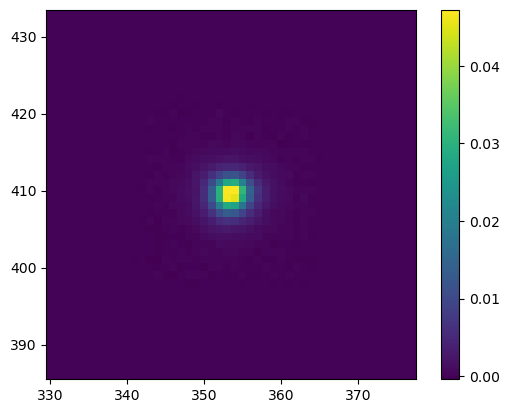

In [5]:
import matplotlib.pyplot as plt

im1 = psf.draw(353.3, 409.6, center=True)

fig, ax = plt.subplots()
extent = (im1.bounds.xmin-0.5, im1.bounds.xmax+0.5, im1.bounds.ymin-0.5, im1.bounds.ymax+0.5)
c = ax.imshow(im1.array, origin='lower', extent=extent)
fig.colorbar(c)
plt.show()

You can also give it an image to draw onto, rather than let it create one itself.  E.g. if you want the PSF centered in a pixel, you can give it an odd-sized image.

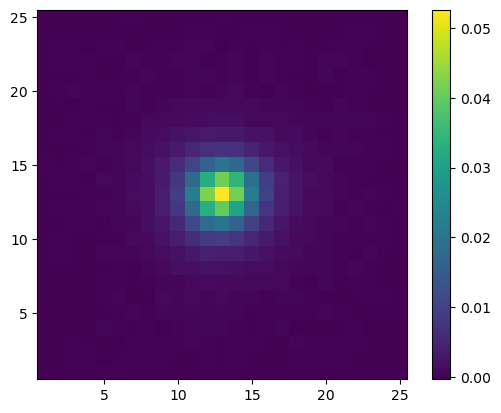

In [6]:
import galsim

im2 = psf.draw(353.3, 409.6, center=True, image=galsim.Image(25,25))

fig, ax = plt.subplots()
extent = (im2.bounds.xmin-0.5, im2.bounds.xmax+0.5, im2.bounds.ymin-0.5, im2.bounds.ymax+0.5)
c = ax.imshow(im2.array, origin='lower', extent=extent)
fig.colorbar(c)
plt.show()

You can also center it at other locations if you prefer.  The default is to center the profile at the same (x,y) value you give it for the interpolation position.  But you can also give an arbitrary position if you want something else.

For instance, in the second case here, we draw onto an existing image where the center is at (0,0), and we want the same sub-pixel offset as the galaxy position.  Notice that this renders the same as drawing at the galaxy position where that is close to the center of the image.

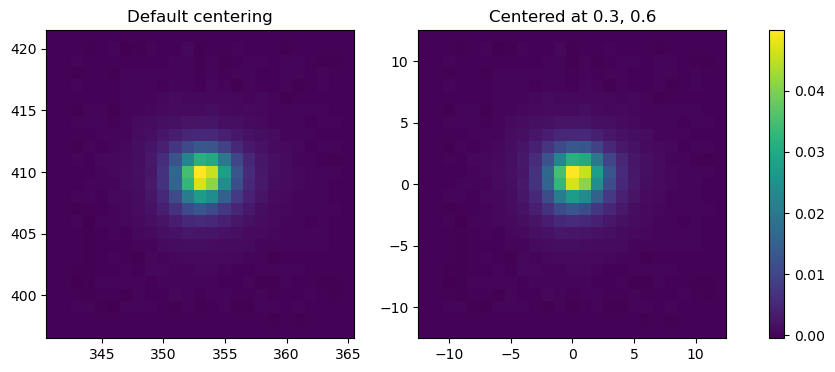

In [7]:
import galsim

im3=galsim.Image(25,25)
im3.setCenter(353, 409)

psf.draw(353.3, 409.6, image=im3)

fig, ax = plt.subplots(1,2, figsize=(11,4))
extent = (im3.bounds.xmin-0.5, im3.bounds.xmax+0.5, im3.bounds.ymin-0.5, im3.bounds.ymax+0.5)
c = ax[0].imshow(im3.array, origin='lower', extent=extent)
ax[0].set_title("Default centering")

im4 = im3.copy()
im4.setCenter(0,0)
psf.draw(353.3, 409.6, center=(0.3, 0.6), image=im3)
extent = (im4.bounds.xmin-0.5, im4.bounds.xmax+0.5, im4.bounds.ymin-0.5, im4.bounds.ymax+0.5)
c = ax[1].imshow(im4.array, origin='lower', extent=extent)
ax[1].set_title("Centered at 0.3, 0.6")
fig.colorbar(c, ax=list(ax.ravel()))
plt.show()

For some use cases, it may be preferable to access the PSF as a GalSim GSObject.  E.g. for forward modeling, you could then convolve it directly with your galaxy model.  Or you may want to draw it directly in Fourier space rather than in real space and then apply an FFT.

The `get_profile` function doesn't just return the profile.  It returns a tuple `(profile, method)`.  The `method` is either 'fft' or 'no_pixel', corresponding to the method one would want to use if drawing this profile onto an image using the galsim `drawImage` method.  This applies either to just directly drawing the PSF or first convolving the PSF by a galaxy (or other object profile) and then drawing.  

The method 'no_pixel' means that the profile model already includes convolution by the pixel response.  This is often called the "effective PSF".  Some PSF models can be set to model the PSF without the pixel convolution.  If that was done, then `get_profile` will return 'fft' for `method`.

Here, we just look at what the PSF looks like in Fourier space by calling `drawKImage`.  Note that the `method` is 'no_pixel', which means that we are actually looking at the Fourier image of the effective PSF.

method =  no_pixel


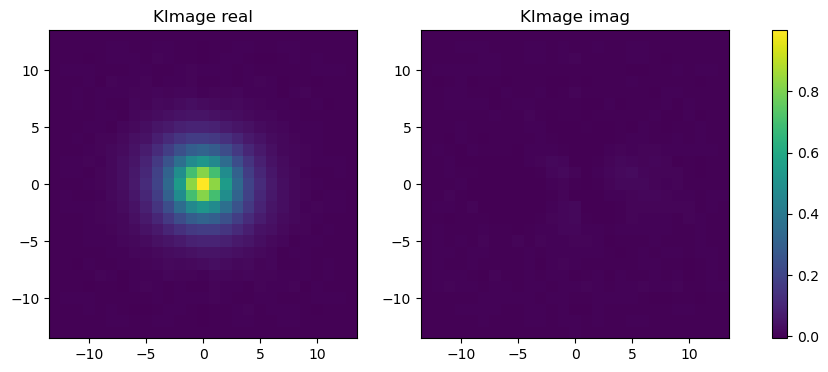

In [8]:
import numpy as np

profile, method = psf.get_profile(353.3, 409.6)

print('method = ',method)

kim = profile.drawKImage()

fig, ax = plt.subplots(1,2, figsize=(11,4))
extent = (kim.bounds.xmin-0.5, kim.bounds.xmax+0.5, kim.bounds.ymin-0.5, kim.bounds.ymax+0.5)
vmin = np.min(kim.array.real)
vmax = np.max(kim.array.real)
c = ax[0].imshow(kim.array.real, origin='lower', extent=extent, vmin=vmin, vmax=vmax) 
ax[1].imshow(kim.array.imag, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
ax[0].set_title('KImage real')
ax[1].set_title('KImage imag')
fig.colorbar(c, ax=ax.ravel().tolist())
plt.show()

Note that the imaginary part isn't exactly zero, even though it's hard to tell here.  A profile that is exactly $180^\circ$ rotationally symmetric has a purely real Fourier image.  This profile is close to that, but not quite, which is typical of realistic PSF images.  Here is the same thing, but using the imaginary part for the color range.

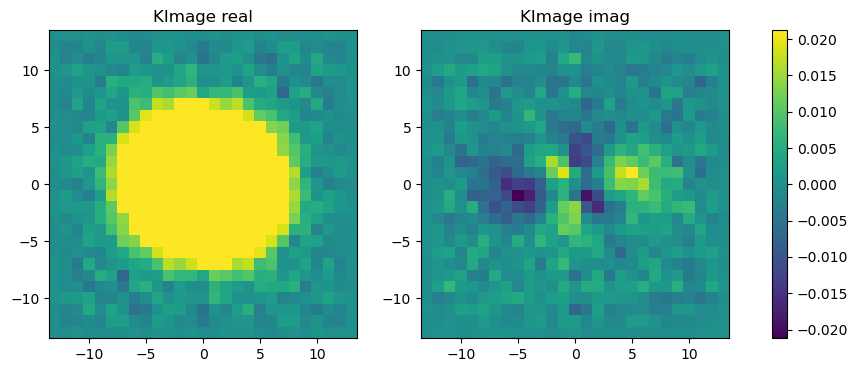

In [9]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
vmin = np.min(kim.array.imag)
vmax = np.max(kim.array.imag)
c = ax[0].imshow(kim.array.real, origin='lower', extent=extent, vmin=vmin, vmax=vmax) 
ax[1].imshow(kim.array.imag, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
ax[0].set_title('KImage real')
ax[1].set_title('KImage imag')
fig.colorbar(c, ax=ax.ravel().tolist())
plt.show()

### Output stats

In addtion to the regular output file with the computed model, Piff can also generate some additional files with various output statistics.  Most of these are in the form of plots, but there is also an HSM Catalog option with measurements of stars and models, which can be used for further analysis.  This is not an exhaustive list of possible output statistics, but it hopefully will give you a feel for the kinds of plots that are available.  See the full documentation for others.

In [10]:
config['output']['stats'] = yaml.safe_load(dedent("""
    -
        # Plot size and shape of the star, model, and difference between them as a function of position.
        type: TwoDHist
        file_name: twod_hist.png
    -
        # Show images of stars, models and differences.
        # By default, it selects a subset of all the stars, but one can force it to show all of them.
        type: Star
        file_name: star.png
    -
        # So-called "rho statistics".  These are correlation functions of the residuals, which are
        # relevant for weak lensing systematic errors.
        type: Rho
        min_sep: 30
        max_sep: 600
        sep_units: arcsec
        bin_size: 0.2
        file_name: rho.png
    -
        # A size-magnitude diagram of the selected stars.
        type: SizeMag
        file_name: size_mag.png
    -
        # An output catalog with size and shape measurements using the HSM adaptive moments algorithm.
        type: HSMCatalog
        file_name: hsm.fits
    """))

If you've already run the PSF model, you can rerun just the stats using the other Piff executable, `plotify` or use the `piff.plotify` function from within Python.

In [11]:
piff.plotify(config)

Reading PSF from file output/D00572501_z_c01.piff
Getting wcs from image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Writing TwoDHistStats plot to file output/twod_hist.png
Writing StarStats plot to file output/star.png
Calculating rho statistics for 111 stars
Writing RhoStats plot to file output/rho.png
Writing SizeMagStats plot to file output/size_mag.png
Calculating shape histograms for 111 stars
Writing HSM catalog to file output/hsm.fits


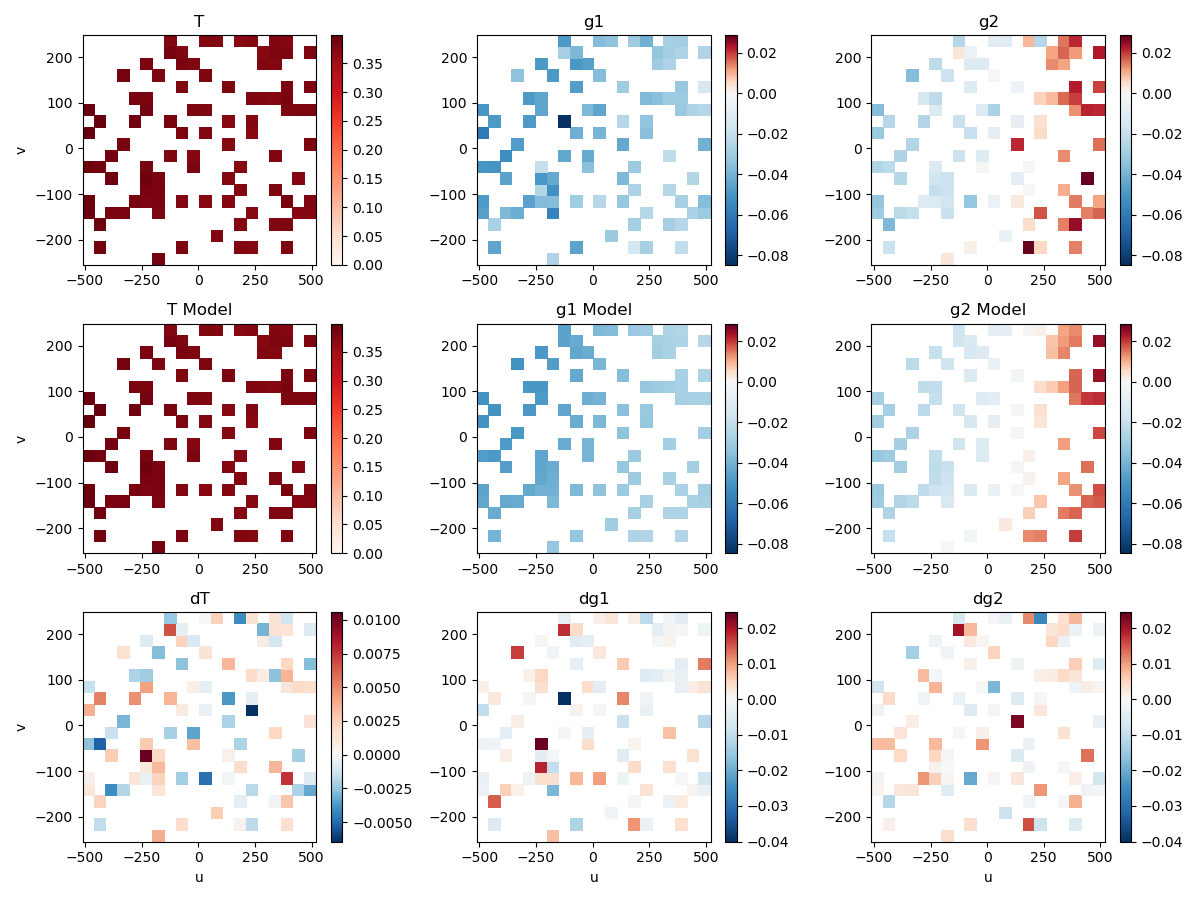

In [12]:
import PIL
from IPython import display
display.display(PIL.Image.open('output/twod_hist.png'))

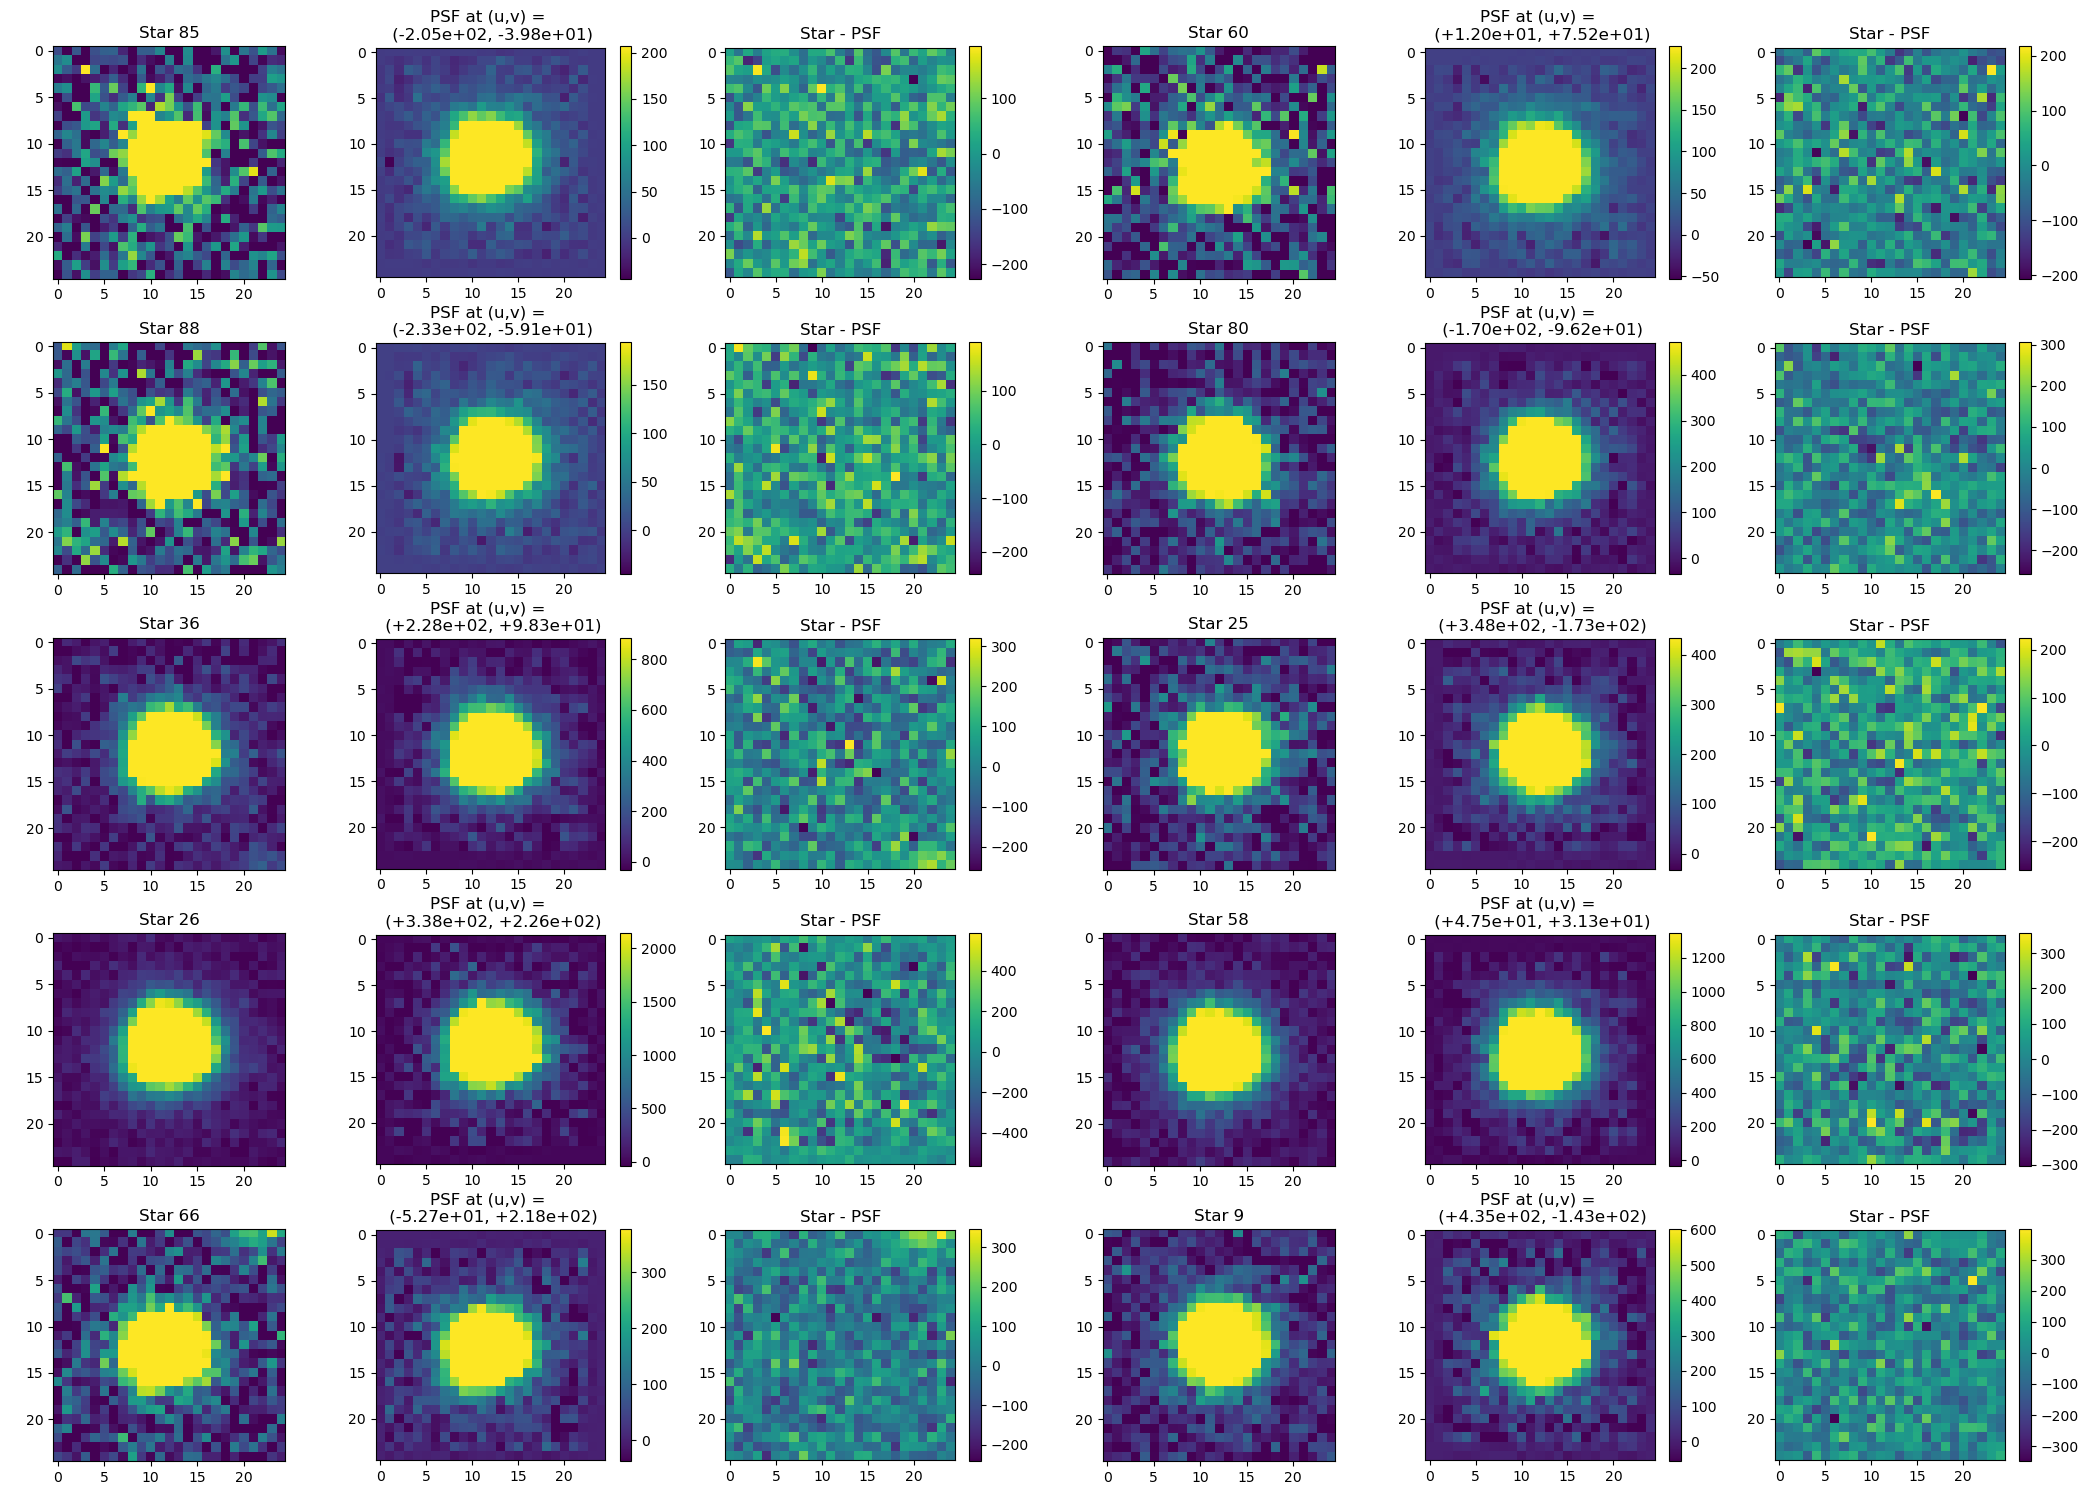

In [13]:
display.display(PIL.Image.open('output/star.png'))

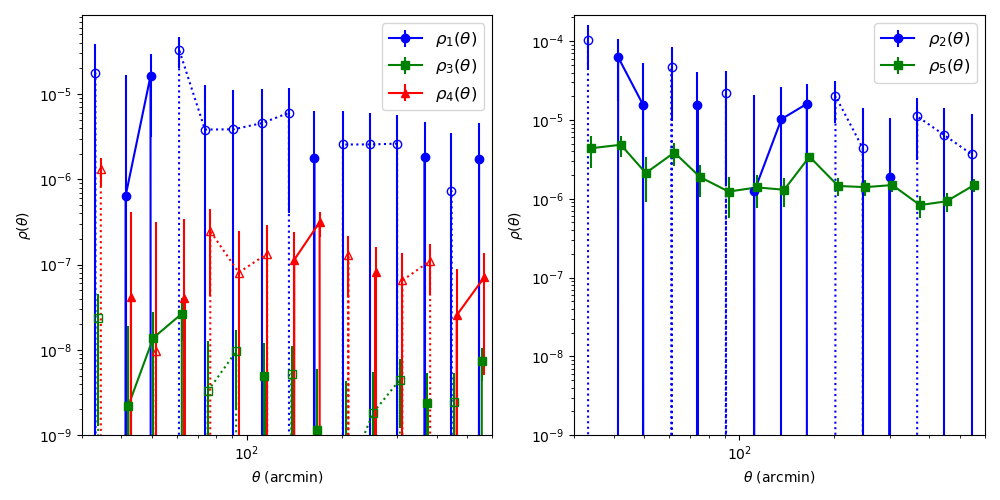

In [14]:
display.display(PIL.Image.open('output/rho.png'))

In [15]:
import fitsio

hsm = fitsio.read('output/hsm.fits')
print(hsm.dtype)

[('u', '>f8'), ('v', '>f8'), ('x', '>f8'), ('y', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('flux', '>f8'), ('reserve', '?'), ('flag_truth', '>i8'), ('flag_model', '>i8'), ('T_data', '>f8'), ('g1_data', '>f8'), ('g2_data', '>f8'), ('T_model', '>f8'), ('g1_model', '>f8'), ('g2_model', '>f8'), ('chipnum', '>f8'), ('SPREAD_MODEL', '>f8'), ('FLAGS', '>f8'), ('snr', '>f8'), ('is_reserve', '>f8')]


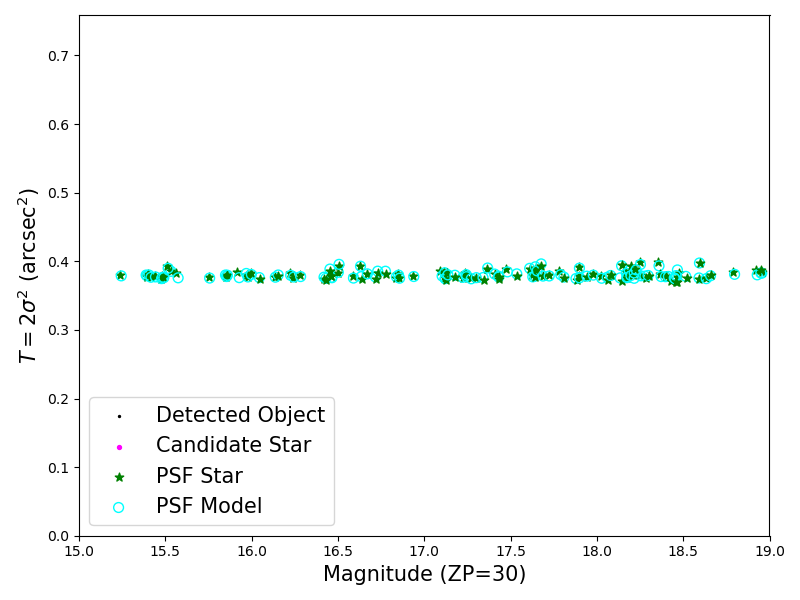

In [16]:
display.display(PIL.Image.open('output/size_mag.png'))

### Size-magnitude selection

The size-magnitude output plot gets rather more interesting if you also use the size-magnitude selector to pick out which stars to use.

Let's switch to an input catalog that includes all detections, not just some selection of star-like objects and have Piff select the probable stars from that using the SizeMag selector.

In [17]:
config['select'] = yaml.safe_load(dedent("""
    type: SizeMag
    
    impurity: 0.03  # Smaller values lead to a purer stellar sample.
                    # Larger values will select more stars at the expese of a less pure sample.
                    # The default is 0.01.
    
    initial_select:
        type: Properties
        where: "np.abs(SPREAD_MODEL) < 3.e-4"

    # All selection schemes can apply further rejection steps to remove obviously bad stars.
    hsm_size_reject: 4
    min_snr: 50
    reserve_frac: 0.2
    seed: 1234
"""))
config['input']['cat_file_name'] = "D00572501_z_c01_r3624p01_red-fullcat.fits"
config['input']['cat_hdu'] = 2

In [18]:
piff.piffify(config)

Getting wcs from image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Reading image file 572501/D00572501_z_c01_r3624p01_immasked.fits.fz
Reading input catalog 572501/D00572501_z_c01_r3624p01_red-fullcat.fits.
Object at position 1986.088361,42.082292 is completely masked.
Skipping this object.
Object at position 1992.648301,83.843551 is completely masked.
Skipping this object.
Object at position 423.552589,206.076870 is completely masked.
Skipping this object.
Object at position 1465.219317,269.561195 is completely masked.
Skipping this object.
Object at position 1079.020395,444.939105 is completely masked.
Skipping this object.
Object at position 254.078617,362.664071 is completely masked.
Skipping this object.
Object at position 1292.020792,711.706583 is completely masked.
Skipping this object.
Object at position 1185.571738,1005.532534 is completely masked.
Skipping this object.
Object at position 1800.961841,1314.240202 is completely masked.
Skipping this object.
Object at p

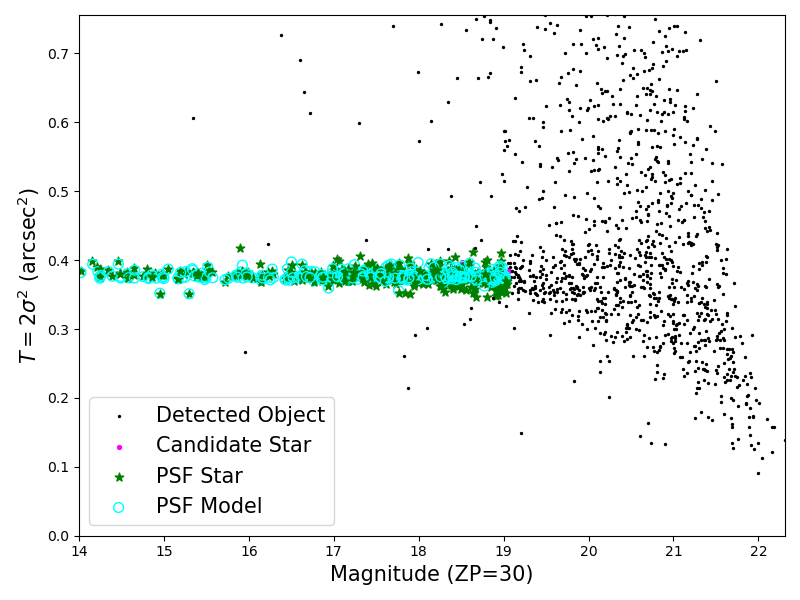

In [19]:
display.display(PIL.Image.open('output/size_mag.png'))